<a href="https://colab.research.google.com/github/mauricioyc/ngcf_pytorch_g61/blob/master/Neural_Graph_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import pandas as pd
from time import time
from datetime import datetime
import torch
import os
import sys

# drive path to the project
source_path = "drive/MyDrive/Machine Learning/git/ngcf_pytorch_g61"
sys.path.insert(0,source_path)

# torch cuda initialization
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)

# Introduction

Neural Graph Collaborative Filtering (NGCF), created by [Wang et al.(2019)] (https://arxiv.org/abs/1905.08108), is a Deep Learning Recommendation algorithm with graph topology that creates user-item embeddings representation and interactions. In this article we will use [MovieLens: ML-100k dataset](https://grouplens.org/datasets/movielens/100k/) to explore [this](https://github.com/metahexane/ngcf_pytorch_g61) PyTorch implementation of the NGCF.





# Background Information

![imagem](https://drive.google.com/uc?export=view&id=1rAQFHvKvVieAI7pVmfYZPTrHuPxn16n2)

# NGCF

In a traditional collaborative filtering algorithm for ML-100k, the user-item interaction can be represented by a sparse matrix $R_{n,m}$ of liked/watched movies, where $n$ is the number of users and $m$ the movies. This matrix can be factored into two feature matrices in the form
$R_{n,m} = U_{n,f} \times I_{f,m}$, where $f$ is the feature vector size as shown in the figure 2. We can call these factors **Embeddings**.

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1uBb6pFf12tU6l29YPMBb_2YCX-T4SBbY" height="300"><figcaption>Figure 2: Matrix factorization of $R_{n,m} = U_{n,f} \times I_{f,m}$.</figcaption></center>
</br>

In the NGCF, the user-item relationship can be interpreted as a bipartite graph, shown in figure 3, in which node $u_i$ and $i_i$ is a unique user and movie embedding, respectively, and the edge represents the movies each user has seen. The graph can be created from the sparce matrix $R_{n,m}$.

<br>
<center><img src="https://drive.google.com/uc?export=view&id=1GO5fqKaC_gRnijLjjff1nvtv4X--wMIw"><figcaption>Figure 3: User-item bipartite graph.</figcaption></center>
</br>

In the paper, the NGCF propagates the messages from the user-item embeddings relationship over the the bipartate graph, being able to capture neighbors information depending on the connectivity order parameterized. For example, a 2nd-oder connectivity can capture the path $u1 \leftarrow i2 \leftarrow u2$ and a 3rd-order connectivity send information to $u1$ through the path $u1 \leftarrow i2 \leftarrow u2 \leftarrow i3$, being able to capture the fact that user 1 might like movie 3.

## 2: NGCF Architecture and Message Propagation

## 2.1: Embedding Layer

The initial user and item embeddings are concatenated in an embedding lookup table as shown in the equation below. This embedding table is initialized using the user and item embeddings with a xavier uniform and will be optimized in an end-to-end fashion by the network.

<br>
<center>$E = [user\_embeddings \space , \space item\_embeddings] = [e_{u_1},...,e_{u_n} \space , \space e_{i_1},...,e_{i_m}]$ </center>
</br>

```python
# initialize weights
def _init_weights(self):
    print("Initializing weights...")
    weight_dict = nn.ParameterDict()

    initializer = torch.nn.init.xavier_uniform_
    
    weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
    weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

# ...

# creating E
def forward(self, u, i, j):
  ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)
```

## 2.2: Embedding Propagation Layers

Message Aggregation

$e^{(l)}_{u} = \text{LeakyReLU}(m^{(l)}_{u \space \leftarrow \space u} + \sum_{i \space \in \space \mathcal{N}_u} m^{(l)}_{u \space \leftarrow \space i})$

<br>
Message definition:

$\begin{equation}
  \begin{cases}
      m^{(l)}_{u \space \leftarrow \space i}  = \frac{1}{\sqrt{|\mathcal{N}_u||\mathcal{N}_i|}}\left(W^{(l)}_1e^{(l-1)}_i + W^{(l)}_2(e^{(l-1)}_i \space \odot \space e^{(l-1)}_u)\right)  \\
      m^{(l)}_{u \space \leftarrow \space u}  = W^{(l)}_1e^{(l-1)}_u \\
    \end{cases}       
\end{equation}$
</br>

<br>
Matrix Form:

$E^{(l)} = \text{LeakyReLU}\left((\mathcal{L} + I)E^{(l-1)}W^{(l)}_1 + \mathcal{L}E^{(l-1)} \space \odot \space E^{(l-1)}W^{(l)}_2\right)$

where $\mathcal{L}$ represents the Laplacian for the user-item graph, which is formulated as:



</br>


In [19]:
import random as rd
import scipy.sparse as sp
import numpy as np
[]
class Data(object):
    def __init__(self, path, batch_size):
        self.path = path
        self.batch_size = batch_size

        train_file = path + '/train.txt'
        test_file = path + '/test.txt'

        #get number of users and items
        self.n_users, self.n_items = 0, 0
        self.n_train, self.n_test = 0, 0
        self.neg_pools = {}

        self.exist_users = []

        # search train_file for max user_id/item_id
        with open(train_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n').split(' ')
                    items = [int(i) for i in l[1:]]
                    # first element is the user_id, rest are items
                    uid = int(l[0])
                    self.exist_users.append(uid)
                    # item/user with highest number is number of items/users
                    self.n_items = max(self.n_items, max(items))
                    self.n_users = max(self.n_users, uid)
                    # number of interactions
                    self.n_train += len(items)

        # search test_file for max item_id
        with open(test_file) as f:
            for l in f.readlines():
                if len(l) > 0:
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')[1:]]
                    except Exception:
                        continue
                    if not items:
                        print("empyt test exists")
                        pass
                    else:
                        self.n_items = max(self.n_items, max(items))
                        self.n_test += len(items)
        # adjust counters: user_id/item_id starts at 0
        self.n_items += 1
        self.n_users += 1

        self.print_statistics()

        # create interactions/ratings matrix 'R' # dok = dictionary of keys
        print('Creating interaction matrices R_train and R_test...')
        t1 = time()
        self.R_train = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32) 
        self.R_test = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)

        self.train_items, self.test_set = {}, {}
        with open(train_file) as f_train:
            with open(test_file) as f_test:
                for l in f_train.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    items = [int(i) for i in l.split(' ')]
                    uid, train_items = items[0], items[1:]
                    # enter 1 if user interacted with item
                    for i in train_items:
                        self.R_train[uid, i] = 1.
                    self.train_items[uid] = train_items

                for l in f_test.readlines():
                    if len(l) == 0: break
                    l = l.strip('\n')
                    try:
                        items = [int(i) for i in l.split(' ')]
                    except Exception:
                        continue
                    uid, test_items = items[0], items[1:]
                    for i in test_items:
                        self.R_test[uid, i] = 1.0
                    self.test_set[uid] = test_items
        print('Complete. Interaction matrices R_train and R_test created in', time() - t1, 'sec')

    # if exist, get adjacency matrix
    def get_adj_mat(self):
        try:
            t1 = time()
            adj_mat = sp.load_npz(self.path + '/s_adj_mat.npz')
            print('Loaded adjacency-matrix (shape:', adj_mat.shape,') in', time() - t1, 'sec.')

        except Exception:
            print('Creating adjacency-matrix...')
            adj_mat = self.create_adj_mat()
            sp.save_npz(self.path + '/s_adj_mat.npz', adj_mat)
        return adj_mat
    
    # create adjancency matrix
    def create_adj_mat(self):
        t1 = time()
        
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32)
        adj_mat = adj_mat.tolil()
        R = self.R_train.tolil() # to list of lists

        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T
        adj_mat = adj_mat.todok()
        print('Complete. Adjacency-matrix created in', adj_mat.shape, time() - t1, 'sec.')

        t2 = time()

        # normalize adjacency matrix
        def normalized_adj_single(adj):
            rowsum = np.array(adj.sum(1))

            d_inv = np.power(rowsum, -.5).flatten()
            d_inv[np.isinf(d_inv)] = 0.
            d_mat_inv = sp.diags(d_inv)

            norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)
            return norm_adj.tocoo()

        print('Transforming adjacency-matrix to NGCF-adjacency matrix...')
        ngcf_adj_mat = normalized_adj_single(adj_mat) + sp.eye(adj_mat.shape[0])

        print('Complete. Transformed adjacency-matrix to NGCF-adjacency matrix in', time() - t2, 'sec.')
        return ngcf_adj_mat.tocsr()

    # create collections of N items that users never interacted with
    def negative_pool(self):
        t1 = time()
        for u in self.train_items.keys():
            neg_items = list(set(range(self.n_items)) - set(self.train_items[u]))
            pools = [rd.choice(neg_items) for _ in range(100)]
            self.neg_pools[u] = pools
        print('refresh negative pools', time() - t1)

    # sample data for mini-batches
    def sample(self):
        if self.batch_size <= self.n_users:
            users = rd.sample(self.exist_users, self.batch_size)
        else:
            users = [rd.choice(self.exist_users) for _ in range(self.batch_size)]

        def sample_pos_items_for_u(u, num):
            pos_items = self.train_items[u]
            n_pos_items = len(pos_items)
            pos_batch = []
            while True:
                if len(pos_batch) == num: break
                pos_id = np.random.randint(low=0, high=n_pos_items, size=1)[0]
                pos_i_id = pos_items[pos_id]

                if pos_i_id not in pos_batch:
                    pos_batch.append(pos_i_id)
            return pos_batch

        def sample_neg_items_for_u(u, num):
            neg_items = []
            while True:
                if len(neg_items) == num: break
                neg_id = np.random.randint(low=0, high=self.n_items,size=1)[0]
                if neg_id not in self.train_items[u] and neg_id not in neg_items:
                    neg_items.append(neg_id)
            return neg_items

        def sample_neg_items_for_u_from_pools(u, num):
            neg_items = list(set(self.neg_pools[u]) - set(self.train_items[u]))
            return rd.sample(neg_items, num)

        pos_items, neg_items = [], []
        for u in users:
            pos_items += sample_pos_items_for_u(u, 1)
            neg_items += sample_neg_items_for_u(u, 1)

        return users, pos_items, neg_items

    def get_num_users_items(self):
        return self.n_users, self.n_items

    def print_statistics(self):
        print('n_users=%d, n_items=%d' % (self.n_users, self.n_items))
        print('n_interactions=%d' % (self.n_train + self.n_test))
        print('n_train=%d, n_test=%d, sparsity=%.5f' % (self.n_train, self.n_test, (self.n_train + self.n_test)/(self.n_users * self.n_items)))


In [22]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
import scipy.sparse as sp

from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NGCF(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, layers, reg, node_dropout, mess_dropout,
        adj_mtx):
        super().__init__()

        # initialize Class attributes
        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.adj_mtx = adj_mtx
        self.laplacian = adj_mtx - sp.eye(adj_mtx.shape[0])
        self.reg = reg
        self.layers = layers
        self.n_layers = len(self.layers)
        self.node_dropout = node_dropout
        self.mess_dropout = mess_dropout

        #self.u_g_embeddings = nn.Parameter(torch.empty(n_users, emb_dim+np.sum(self.layers)))
        #self.i_g_embeddings = nn.Parameter(torch.empty(n_items, emb_dim+np.sum(self.layers)))

        # Initialize weights
        self.weight_dict = self._init_weights()
        print("Weights initialized.")

        # Create Matrix 'A', PyTorch sparse tensor of SP adjacency_mtx
        self.A = self._convert_sp_mat_to_sp_tensor(self.adj_mtx)
        self.L = self._convert_sp_mat_to_sp_tensor(self.laplacian)

    # initialize weights
    def _init_weights(self):
        print("Initializing weights...")
        weight_dict = nn.ParameterDict()

        initializer = torch.nn.init.xavier_uniform_
        
        weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(device)))
        weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(device)))

        weight_size_list = [self.emb_dim] + self.layers

        for k in range(self.n_layers):
            weight_dict['W_gc_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_gc_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
            
            weight_dict['W_bi_%d' %k] = nn.Parameter(initializer(torch.empty(weight_size_list[k], weight_size_list[k+1]).to(device)))
            weight_dict['b_bi_%d' %k] = nn.Parameter(initializer(torch.empty(1, weight_size_list[k+1]).to(device)))
           
        return weight_dict

    # convert sparse matrix into sparse PyTorch tensor
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(device)
        return res

    # apply node_dropout
    def _droupout_sparse(self, X):
        """
        Drop individual locations in X
        
        Arguments:
        ---------
        X = adjacency matrix (PyTorch sparse tensor)
        dropout = fraction of nodes to drop
        noise_shape = number of non non-zero entries of X
        """
        
        node_dropout_mask = ((self.node_dropout) + torch.rand(X._nnz())).floor().bool().to(device)
        i = X.coalesce().indices()
        v = X.coalesce()._values()
        i[:,node_dropout_mask] = 0
        v[node_dropout_mask] = 0
        X_dropout = torch.sparse.FloatTensor(i, v, X.shape).to(X.device)

        return  X_dropout.mul(1/(1-self.node_dropout))

    def forward(self, u, i, j):
        """
        Computes the forward pass
        
        Arguments:
        ---------
        u = user
        i = positive item (user interacted with item)
        j = negative item (user did not interact with item)
        """
        # apply drop-out mask
        A_hat = self._droupout_sparse(self.A) if self.node_dropout > 0 else self.A
        L_hat = self._droupout_sparse(self.L) if self.node_dropout > 0 else self.L

        ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)

        all_embeddings = [ego_embeddings]

        # forward pass for 'n' propagation layers
        for k in range(self.n_layers):

            # weighted sum messages of neighbours
            side_embeddings = torch.sparse.mm(A_hat, ego_embeddings)
            side_L_embeddings = torch.sparse.mm(L_hat, ego_embeddings)

            # transformed sum weighted sum messages of neighbours
            sum_embeddings = torch.matmul(side_embeddings, self.weight_dict['W_gc_%d' % k]) + self.weight_dict['b_gc_%d' % k]

            # bi messages of neighbours
            bi_embeddings = torch.mul(ego_embeddings, side_L_embeddings)
            # transformed bi messages of neighbours
            bi_embeddings = torch.matmul(bi_embeddings, self.weight_dict['W_bi_%d' % k]) + self.weight_dict['b_bi_%d' % k]

            # non-linear activation 
            ego_embeddings = F.leaky_relu(sum_embeddings + bi_embeddings)
            # + message dropout
            mess_dropout_mask = nn.Dropout(self.mess_dropout)
            ego_embeddings = mess_dropout_mask(ego_embeddings)

            # normalize activation
            norm_embeddings = F.normalize(ego_embeddings, p=2, dim=1)

            all_embeddings.append(norm_embeddings)

        all_embeddings = torch.cat(all_embeddings, 1)
        
        # back to user/item dimension
        u_g_embeddings, i_g_embeddings = all_embeddings.split([self.n_users, self.n_items], 0)

        self.u_g_embeddings = nn.Parameter(u_g_embeddings)
        self.i_g_embeddings = nn.Parameter(i_g_embeddings)
        
        u_emb = u_g_embeddings[u] # user embeddings
        p_emb = i_g_embeddings[i] # positive item embeddings
        n_emb = i_g_embeddings[j] # negative item embeddings

        y_ui = torch.mul(u_emb, p_emb).sum(dim=1)
        y_uj = torch.mul(u_emb, n_emb).sum(dim=1)
        log_prob = (torch.log(torch.sigmoid(y_ui-y_uj))).mean()

        # compute bpr-loss
        bpr_loss = -log_prob
        if self.reg > 0.:
            l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
            l2reg  = self.reg*l2norm
            bpr_loss =  -log_prob + l2reg

        return bpr_loss

In [23]:
# Parameters Inicialization

data_dir = source_path+'/data/'
dataset = 'ml-100k'
batch_size = 1024
layers = eval('[64,64]')
emb_dim = 64
lr = 0.0001
reg = 1e-5
mess_dropout = 0.1
node_dropout = 0.
k = 10
n_epochs = 400
eval_N = 1
save_results = 1
results_dir = 'results'

In [24]:
data_generator = Data(path=data_dir + dataset, batch_size=batch_size)
adj_mtx = data_generator.get_adj_mat()

model = NGCF(data_generator.n_users, 
              data_generator.n_items,
              emb_dim,
              layers,
              reg,
              node_dropout,
              mess_dropout,
              adj_mtx)

n_users=943, n_items=1682
n_interactions=100000
n_train=80064, n_test=19936, sparsity=0.06305
Creating interaction matrices R_train and R_test...
Complete. Interaction matrices R_train and R_test created in 1.0807478427886963 sec
Loaded adjacency-matrix (shape: (2625, 2625) ) in 0.018945932388305664 sec.
Initializing weights...


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Weights initialized.


In [25]:
# apply drop-out mask
A_hat = model._droupout_sparse(model.A) if model.node_dropout > 0 else model.A
L_hat = model._droupout_sparse(model.L) if model.node_dropout > 0 else model.L

ego_embeddings = torch.cat([model.weight_dict['user_embedding'], model.weight_dict['item_embedding']], 0)

In [27]:
ego_embeddings.shape

torch.Size([2625, 64])

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [6]:
# Parameters Inicialization

data_dir = source_path+'/data/'
dataset = 'ml-100k'
batch_size = 1024
layers = eval('[64,64]')
emb_dim = 64
lr = 0.0001
reg = 1e-5
mess_dropout = 0.1
node_dropout = 0.
k = 10
n_epochs = 400
eval_N = 1
save_results = 1
results_dir = 'results'


Evaluate current model:
 Epoch: 10, Validation time: 1.15s 
 Loss: 34.9819: 
 Recall@10: 0.0501 
 NDCG@10: 0.2367


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 11, Training time: 4.19s, Loss: 33.9161
Evaluate current model:
 Epoch: 11, Validation time: 1.12s 
 Loss: 33.9161: 
 Recall@10: 0.0437 
 NDCG@10: 0.2262


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 12, Training time: 4.21s, Loss: 32.7651
Evaluate current model:
 Epoch: 12, Validation time: 1.11s 
 Loss: 32.7651: 
 Recall@10: 0.0556 
 NDCG@10: 0.2607


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 13, Training time: 4.19s, Loss: 31.4561
Evaluate current model:
 Epoch: 13, Validation time: 1.12s 
 Loss: 31.4561: 
 Recall@10: 0.0521 
 NDCG@10: 0.2597


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 14, Training time: 4.26s, Loss: 30.6961
Evaluate current model:
 Epoch: 14, Validation time: 1.13s 
 Loss: 30.6961: 
 Recall@10: 0.0558 
 NDCG@10: 0.2883


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 15, Training time: 4.15s, Loss: 30.1188
Evaluate current model:
 Epoch: 15, Validation time: 1.11s 
 Loss: 30.1188: 
 Recall@10: 0.0592 
 NDCG@10: 0.2960


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 16, Training time: 4.34s, Loss: 29.4203
Evaluate current model:
 Epoch: 16, Validation time: 1.14s 
 Loss: 29.4203: 
 Recall@10: 0.0565 
 NDCG@10: 0.2824


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 17, Training time: 4.25s, Loss: 28.4884
Evaluate current model:
 Epoch: 17, Validation time: 1.15s 
 Loss: 28.4884: 
 Recall@10: 0.0758 
 NDCG@10: 0.3202


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 18, Training time: 4.32s, Loss: 27.5151
Evaluate current model:
 Epoch: 18, Validation time: 1.15s 
 Loss: 27.5151: 
 Recall@10: 0.0710 
 NDCG@10: 0.3070


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 19, Training time: 4.20s, Loss: 26.8739
Evaluate current model:
 Epoch: 19, Validation time: 1.13s 
 Loss: 26.8739: 
 Recall@10: 0.0765 
 NDCG@10: 0.3228


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 20, Training time: 4.04s, Loss: 26.4616
Evaluate current model:
 Epoch: 20, Validation time: 1.11s 
 Loss: 26.4616: 
 Recall@10: 0.0726 
 NDCG@10: 0.3136


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 21, Training time: 4.27s, Loss: 26.2890
Evaluate current model:
 Epoch: 21, Validation time: 1.11s 
 Loss: 26.2890: 
 Recall@10: 0.0762 
 NDCG@10: 0.3357


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 22, Training time: 4.16s, Loss: 25.7785
Evaluate current model:
 Epoch: 22, Validation time: 1.15s 
 Loss: 25.7785: 
 Recall@10: 0.0833 
 NDCG@10: 0.3467


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 23, Training time: 4.44s, Loss: 25.4927
Evaluate current model:
 Epoch: 23, Validation time: 1.11s 
 Loss: 25.4927: 
 Recall@10: 0.0825 
 NDCG@10: 0.3611


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 24, Training time: 4.35s, Loss: 25.5589
Evaluate current model:
 Epoch: 24, Validation time: 1.14s 
 Loss: 25.5589: 
 Recall@10: 0.0846 
 NDCG@10: 0.3725


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 25, Training time: 4.14s, Loss: 25.1124
Evaluate current model:
 Epoch: 25, Validation time: 1.11s 
 Loss: 25.1124: 
 Recall@10: 0.0958 
 NDCG@10: 0.3709


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 26, Training time: 4.41s, Loss: 25.1572
Evaluate current model:
 Epoch: 26, Validation time: 1.14s 
 Loss: 25.1572: 
 Recall@10: 0.0985 
 NDCG@10: 0.3801


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 27, Training time: 4.48s, Loss: 24.8275
Evaluate current model:
 Epoch: 27, Validation time: 1.12s 
 Loss: 24.8275: 
 Recall@10: 0.0882 
 NDCG@10: 0.3695


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 28, Training time: 4.14s, Loss: 24.6486
Evaluate current model:
 Epoch: 28, Validation time: 1.11s 
 Loss: 24.6486: 
 Recall@10: 0.0991 
 NDCG@10: 0.3953


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 29, Training time: 4.30s, Loss: 24.3432
Evaluate current model:
 Epoch: 29, Validation time: 1.15s 
 Loss: 24.3432: 
 Recall@10: 0.0972 
 NDCG@10: 0.3981


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 30, Training time: 4.03s, Loss: 24.3153
Evaluate current model:
 Epoch: 30, Validation time: 1.12s 
 Loss: 24.3153: 
 Recall@10: 0.1059 
 NDCG@10: 0.4075


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 31, Training time: 4.49s, Loss: 24.1162
Evaluate current model:
 Epoch: 31, Validation time: 1.14s 
 Loss: 24.1162: 
 Recall@10: 0.0983 
 NDCG@10: 0.4054


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 32, Training time: 4.38s, Loss: 23.9597
Evaluate current model:
 Epoch: 32, Validation time: 1.13s 
 Loss: 23.9597: 
 Recall@10: 0.1086 
 NDCG@10: 0.4197


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 33, Training time: 4.32s, Loss: 23.8884
Evaluate current model:
 Epoch: 33, Validation time: 1.11s 
 Loss: 23.8884: 
 Recall@10: 0.1091 
 NDCG@10: 0.4170


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 34, Training time: 4.29s, Loss: 23.9479
Evaluate current model:
 Epoch: 34, Validation time: 1.13s 
 Loss: 23.9479: 
 Recall@10: 0.1063 
 NDCG@10: 0.4214


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 35, Training time: 4.12s, Loss: 23.5901
Evaluate current model:
 Epoch: 35, Validation time: 1.12s 
 Loss: 23.5901: 
 Recall@10: 0.1120 
 NDCG@10: 0.4283


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 36, Training time: 4.18s, Loss: 23.5599
Evaluate current model:
 Epoch: 36, Validation time: 1.15s 
 Loss: 23.5599: 
 Recall@10: 0.1074 
 NDCG@10: 0.4257


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 37, Training time: 4.04s, Loss: 23.4794
Evaluate current model:
 Epoch: 37, Validation time: 1.12s 
 Loss: 23.4794: 
 Recall@10: 0.1207 
 NDCG@10: 0.4453


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 38, Training time: 4.18s, Loss: 23.2912
Evaluate current model:
 Epoch: 38, Validation time: 1.13s 
 Loss: 23.2912: 
 Recall@10: 0.1274 
 NDCG@10: 0.4586


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 39, Training time: 4.20s, Loss: 23.2236
Evaluate current model:
 Epoch: 39, Validation time: 1.14s 
 Loss: 23.2236: 
 Recall@10: 0.1238 
 NDCG@10: 0.4596


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 40, Training time: 4.60s, Loss: 23.1948
Evaluate current model:
 Epoch: 40, Validation time: 1.11s 
 Loss: 23.1948: 
 Recall@10: 0.1304 
 NDCG@10: 0.4581


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 41, Training time: 4.35s, Loss: 22.7165
Evaluate current model:
 Epoch: 41, Validation time: 1.13s 
 Loss: 22.7165: 
 Recall@10: 0.1314 
 NDCG@10: 0.4592


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 42, Training time: 4.21s, Loss: 22.7314
Evaluate current model:
 Epoch: 42, Validation time: 1.13s 
 Loss: 22.7314: 
 Recall@10: 0.1208 
 NDCG@10: 0.4607


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 43, Training time: 4.38s, Loss: 22.6795
Evaluate current model:
 Epoch: 43, Validation time: 1.13s 
 Loss: 22.6795: 
 Recall@10: 0.1345 
 NDCG@10: 0.4654


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 44, Training time: 4.19s, Loss: 22.6807
Evaluate current model:
 Epoch: 44, Validation time: 1.16s 
 Loss: 22.6807: 
 Recall@10: 0.1311 
 NDCG@10: 0.4716


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 45, Training time: 4.02s, Loss: 22.4766
Evaluate current model:
 Epoch: 45, Validation time: 1.15s 
 Loss: 22.4766: 
 Recall@10: 0.1298 
 NDCG@10: 0.4707


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 46, Training time: 4.20s, Loss: 22.4799
Evaluate current model:
 Epoch: 46, Validation time: 1.15s 
 Loss: 22.4799: 
 Recall@10: 0.1311 
 NDCG@10: 0.4831


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 47, Training time: 4.39s, Loss: 22.3081
Evaluate current model:
 Epoch: 47, Validation time: 1.16s 
 Loss: 22.3081: 
 Recall@10: 0.1380 
 NDCG@10: 0.4998


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 48, Training time: 4.37s, Loss: 22.0237
Evaluate current model:
 Epoch: 48, Validation time: 1.12s 
 Loss: 22.0237: 
 Recall@10: 0.1390 
 NDCG@10: 0.5023


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 49, Training time: 4.24s, Loss: 22.0896
Evaluate current model:
 Epoch: 49, Validation time: 1.13s 
 Loss: 22.0896: 
 Recall@10: 0.1341 
 NDCG@10: 0.4846


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 50, Training time: 4.14s, Loss: 21.9872
Evaluate current model:
 Epoch: 50, Validation time: 1.15s 
 Loss: 21.9872: 
 Recall@10: 0.1376 
 NDCG@10: 0.5019


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 51, Training time: 4.09s, Loss: 21.9160
Evaluate current model:
 Epoch: 51, Validation time: 1.13s 
 Loss: 21.9160: 
 Recall@10: 0.1366 
 NDCG@10: 0.5022


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 52, Training time: 4.17s, Loss: 21.6302
Evaluate current model:
 Epoch: 52, Validation time: 1.14s 
 Loss: 21.6302: 
 Recall@10: 0.1433 
 NDCG@10: 0.5246


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 53, Training time: 4.21s, Loss: 21.7743
Evaluate current model:
 Epoch: 53, Validation time: 1.13s 
 Loss: 21.7743: 
 Recall@10: 0.1431 
 NDCG@10: 0.5203


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 54, Training time: 4.43s, Loss: 21.4978
Evaluate current model:
 Epoch: 54, Validation time: 1.11s 
 Loss: 21.4978: 
 Recall@10: 0.1437 
 NDCG@10: 0.5186


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 55, Training time: 4.38s, Loss: 21.4471
Evaluate current model:
 Epoch: 55, Validation time: 1.12s 
 Loss: 21.4471: 
 Recall@10: 0.1422 
 NDCG@10: 0.5163


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 56, Training time: 4.17s, Loss: 21.2139
Evaluate current model:
 Epoch: 56, Validation time: 1.13s 
 Loss: 21.2139: 
 Recall@10: 0.1455 
 NDCG@10: 0.5179


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 57, Training time: 4.22s, Loss: 21.2633
Evaluate current model:
 Epoch: 57, Validation time: 1.15s 
 Loss: 21.2633: 
 Recall@10: 0.1463 
 NDCG@10: 0.5256


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 58, Training time: 4.42s, Loss: 21.2160
Evaluate current model:
 Epoch: 58, Validation time: 1.14s 
 Loss: 21.2160: 
 Recall@10: 0.1466 
 NDCG@10: 0.5245


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 59, Training time: 4.11s, Loss: 21.1629
Evaluate current model:
 Epoch: 59, Validation time: 1.14s 
 Loss: 21.1629: 
 Recall@10: 0.1476 
 NDCG@10: 0.5375


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 60, Training time: 4.19s, Loss: 21.1346
Evaluate current model:
 Epoch: 60, Validation time: 1.12s 
 Loss: 21.1346: 
 Recall@10: 0.1521 
 NDCG@10: 0.5279


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 61, Training time: 4.43s, Loss: 20.9031
Evaluate current model:
 Epoch: 61, Validation time: 1.14s 
 Loss: 20.9031: 
 Recall@10: 0.1512 
 NDCG@10: 0.5313


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 62, Training time: 4.35s, Loss: 20.7512
Evaluate current model:
 Epoch: 62, Validation time: 1.14s 
 Loss: 20.7512: 
 Recall@10: 0.1482 
 NDCG@10: 0.5146


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 63, Training time: 4.32s, Loss: 20.9944
Evaluate current model:
 Epoch: 63, Validation time: 1.13s 
 Loss: 20.9944: 
 Recall@10: 0.1524 
 NDCG@10: 0.5348


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 64, Training time: 4.23s, Loss: 20.7634
Evaluate current model:
 Epoch: 64, Validation time: 1.15s 
 Loss: 20.7634: 
 Recall@10: 0.1509 
 NDCG@10: 0.5337


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 65, Training time: 4.24s, Loss: 20.6860
Evaluate current model:
 Epoch: 65, Validation time: 1.19s 
 Loss: 20.6860: 
 Recall@10: 0.1507 
 NDCG@10: 0.5364


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 66, Training time: 4.18s, Loss: 20.4324
Evaluate current model:
 Epoch: 66, Validation time: 1.17s 
 Loss: 20.4324: 
 Recall@10: 0.1544 
 NDCG@10: 0.5280


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 67, Training time: 4.47s, Loss: 20.3202
Evaluate current model:
 Epoch: 67, Validation time: 1.12s 
 Loss: 20.3202: 
 Recall@10: 0.1556 
 NDCG@10: 0.5422


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 68, Training time: 4.18s, Loss: 20.4694
Evaluate current model:
 Epoch: 68, Validation time: 1.12s 
 Loss: 20.4694: 
 Recall@10: 0.1569 
 NDCG@10: 0.5464


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 69, Training time: 4.47s, Loss: 20.2546
Evaluate current model:
 Epoch: 69, Validation time: 1.14s 
 Loss: 20.2546: 
 Recall@10: 0.1603 
 NDCG@10: 0.5523


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 70, Training time: 4.39s, Loss: 20.3144
Evaluate current model:
 Epoch: 70, Validation time: 1.11s 
 Loss: 20.3144: 
 Recall@10: 0.1590 
 NDCG@10: 0.5406


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 71, Training time: 4.13s, Loss: 19.9786
Evaluate current model:
 Epoch: 71, Validation time: 1.11s 
 Loss: 19.9786: 
 Recall@10: 0.1562 
 NDCG@10: 0.5489


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 72, Training time: 4.41s, Loss: 19.8977
Evaluate current model:
 Epoch: 72, Validation time: 1.14s 
 Loss: 19.8977: 
 Recall@10: 0.1614 
 NDCG@10: 0.5623


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 73, Training time: 4.20s, Loss: 20.1384
Evaluate current model:
 Epoch: 73, Validation time: 1.13s 
 Loss: 20.1384: 
 Recall@10: 0.1602 
 NDCG@10: 0.5556


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 74, Training time: 4.12s, Loss: 19.8452
Evaluate current model:
 Epoch: 74, Validation time: 1.12s 
 Loss: 19.8452: 
 Recall@10: 0.1623 
 NDCG@10: 0.5625


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 75, Training time: 4.13s, Loss: 19.6446
Evaluate current model:
 Epoch: 75, Validation time: 1.13s 
 Loss: 19.6446: 
 Recall@10: 0.1636 
 NDCG@10: 0.5655


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 76, Training time: 4.26s, Loss: 19.6461
Evaluate current model:
 Epoch: 76, Validation time: 1.16s 
 Loss: 19.6461: 
 Recall@10: 0.1661 
 NDCG@10: 0.5653


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 77, Training time: 4.47s, Loss: 19.4810
Evaluate current model:
 Epoch: 77, Validation time: 1.15s 
 Loss: 19.4810: 
 Recall@10: 0.1646 
 NDCG@10: 0.5616


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 78, Training time: 4.27s, Loss: 19.3175
Evaluate current model:
 Epoch: 78, Validation time: 1.12s 
 Loss: 19.3175: 
 Recall@10: 0.1651 
 NDCG@10: 0.5650


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 79, Training time: 4.34s, Loss: 19.3304
Evaluate current model:
 Epoch: 79, Validation time: 1.13s 
 Loss: 19.3304: 
 Recall@10: 0.1681 
 NDCG@10: 0.5698


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 80, Training time: 4.26s, Loss: 19.1583
Evaluate current model:
 Epoch: 80, Validation time: 1.11s 
 Loss: 19.1583: 
 Recall@10: 0.1676 
 NDCG@10: 0.5695


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 81, Training time: 4.18s, Loss: 19.0337
Evaluate current model:
 Epoch: 81, Validation time: 1.14s 
 Loss: 19.0337: 
 Recall@10: 0.1720 
 NDCG@10: 0.5802


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 82, Training time: 4.15s, Loss: 19.0269
Evaluate current model:
 Epoch: 82, Validation time: 1.13s 
 Loss: 19.0269: 
 Recall@10: 0.1671 
 NDCG@10: 0.5703


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 83, Training time: 4.49s, Loss: 19.0736
Evaluate current model:
 Epoch: 83, Validation time: 1.13s 
 Loss: 19.0736: 
 Recall@10: 0.1700 
 NDCG@10: 0.5862


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 84, Training time: 4.24s, Loss: 18.8482
Evaluate current model:
 Epoch: 84, Validation time: 1.13s 
 Loss: 18.8482: 
 Recall@10: 0.1698 
 NDCG@10: 0.5741


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 85, Training time: 4.49s, Loss: 18.7838
Evaluate current model:
 Epoch: 85, Validation time: 1.11s 
 Loss: 18.7838: 
 Recall@10: 0.1718 
 NDCG@10: 0.5749


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 86, Training time: 4.36s, Loss: 18.5171
Evaluate current model:
 Epoch: 86, Validation time: 1.13s 
 Loss: 18.5171: 
 Recall@10: 0.1728 
 NDCG@10: 0.5815


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 87, Training time: 4.20s, Loss: 18.4600
Evaluate current model:
 Epoch: 87, Validation time: 1.11s 
 Loss: 18.4600: 
 Recall@10: 0.1759 
 NDCG@10: 0.5943


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 88, Training time: 4.23s, Loss: 18.7235
Evaluate current model:
 Epoch: 88, Validation time: 1.11s 
 Loss: 18.7235: 
 Recall@10: 0.1735 
 NDCG@10: 0.5828


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 89, Training time: 4.37s, Loss: 18.4328
Evaluate current model:
 Epoch: 89, Validation time: 1.11s 
 Loss: 18.4328: 
 Recall@10: 0.1752 
 NDCG@10: 0.5852


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 90, Training time: 4.27s, Loss: 18.1052
Evaluate current model:
 Epoch: 90, Validation time: 1.14s 
 Loss: 18.1052: 
 Recall@10: 0.1770 
 NDCG@10: 0.5861


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 91, Training time: 4.33s, Loss: 18.1874
Evaluate current model:
 Epoch: 91, Validation time: 1.15s 
 Loss: 18.1874: 
 Recall@10: 0.1757 
 NDCG@10: 0.5856


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 92, Training time: 4.36s, Loss: 18.0947
Evaluate current model:
 Epoch: 92, Validation time: 1.13s 
 Loss: 18.0947: 
 Recall@10: 0.1801 
 NDCG@10: 0.5919


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 93, Training time: 4.14s, Loss: 18.1468
Evaluate current model:
 Epoch: 93, Validation time: 1.12s 
 Loss: 18.1468: 
 Recall@10: 0.1797 
 NDCG@10: 0.5887


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 94, Training time: 4.32s, Loss: 18.0050
Evaluate current model:
 Epoch: 94, Validation time: 1.13s 
 Loss: 18.0050: 
 Recall@10: 0.1821 
 NDCG@10: 0.5920


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 95, Training time: 4.24s, Loss: 17.8379
Evaluate current model:
 Epoch: 95, Validation time: 1.12s 
 Loss: 17.8379: 
 Recall@10: 0.1755 
 NDCG@10: 0.5862


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 96, Training time: 4.23s, Loss: 17.7456
Evaluate current model:
 Epoch: 96, Validation time: 1.15s 
 Loss: 17.7456: 
 Recall@10: 0.1789 
 NDCG@10: 0.5899


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 97, Training time: 4.32s, Loss: 17.8102
Evaluate current model:
 Epoch: 97, Validation time: 1.12s 
 Loss: 17.8102: 
 Recall@10: 0.1784 
 NDCG@10: 0.5978


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 98, Training time: 4.06s, Loss: 17.4973
Evaluate current model:
 Epoch: 98, Validation time: 1.13s 
 Loss: 17.4973: 
 Recall@10: 0.1787 
 NDCG@10: 0.5950


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:550: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch: 99, Training time: 4.14s, Loss: 17.6733
Evaluate current model:
 Epoch: 99, Validation time: 1.12s 
 Loss: 17.6733: 
 Recall@10: 0.1788 
 NDCG@10: 0.5887
Early stopping at step: 5 log:0.17875784635543823


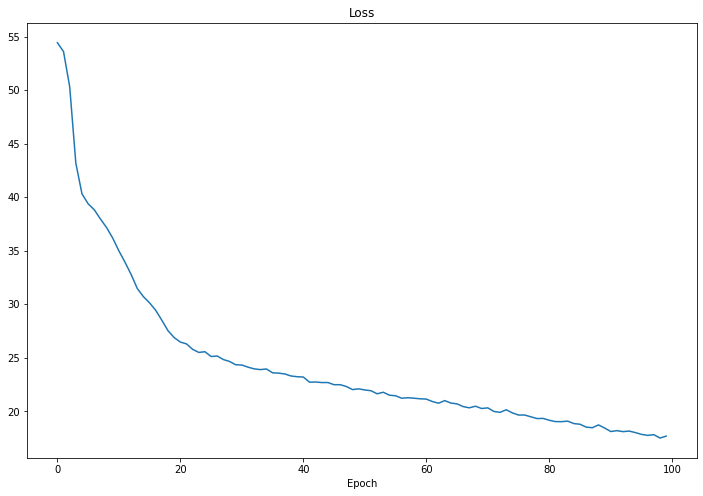

In [ ]:
# generate the NGCF-adjacency matrix
data_generator = Data(path=data_dir + dataset, batch_size=batch_size)
adj_mtx = data_generator.get_adj_mat()

# create model name and save
modelname =  "NGCF" + \
    "_bs_" + str(batch_size) + \
    "_nemb_" + str(emb_dim) + \
    "_layers_" + str(layers) + \
    "_nodedr_" + str(node_dropout) + \
    "_messdr_" + str(mess_dropout) + \
    "_reg_" + str(reg) + \
    "_lr_"  + str(lr)

# create NGCF model
model = NGCF(data_generator.n_users, 
              data_generator.n_items,
              emb_dim,
              layers,
              reg,
              node_dropout,
              mess_dropout,
              adj_mtx)
if use_cuda:
    model = model.cuda()

# current best metric
cur_best_metric = 0

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Set values for early stopping
cur_best_loss, stopping_step, should_stop = 1e3, 0, False
today = datetime.now()

print("Start at " + str(today))
print("Using " + str(device) + " for computations")
print("Params on CUDA: " + str(next(model.parameters()).is_cuda))

results = {"Epoch": [],
            "Loss": [],
            "Recall": [],
            "NDCG": [],
            "Training Time": []}

for epoch in range(n_epochs):

    t1 = time()
    loss = train(model, data_generator, optimizer)
    training_time = time()-t1
    print("Epoch: {}, Training time: {:.2f}s, Loss: {:.4f}".
        format(epoch, training_time, loss))

    # print test evaluation metrics every N epochs (provided by eval_N)
    if epoch % eval_N  == (eval_N - 1):
        with torch.no_grad():
            t2 = time()
            recall, ndcg = eval_model(model.u_g_embeddings.detach(),
                                      model.i_g_embeddings.detach(),
                                      data_generator.R_train,
                                      data_generator.R_test,
                                      k)
        print(
            "Evaluate current model:\n",
            "Epoch: {}, Validation time: {:.2f}s".format(epoch, time()-t2),"\n",
            "Loss: {:.4f}:".format(loss), "\n",
            "Recall@{}: {:.4f}".format(k, recall), "\n",
            "NDCG@{}: {:.4f}".format(k, ndcg)
            )

        cur_best_metric, stopping_step, should_stop = \
        early_stopping(recall, cur_best_metric, stopping_step, flag_step=5)

        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(recall.item())
        results['NDCG'].append(ndcg.item())
        results['Training Time'].append(training_time)
    else:
        # save results in dict
        results['Epoch'].append(epoch)
        results['Loss'].append(loss)
        results['Recall'].append(None)
        results['NDCG'].append(None)
        results['Training Time'].append(training_time)

    if should_stop == True: break

# save
if save_results:
    date = today.strftime("%d%m%Y_%H%M")

    # save model as .pt file
    if os.path.isdir("./models"):
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")
    else:
        os.mkdir("./models")
        torch.save(model.state_dict(), "./models/" + str(date) + "_" + modelname + "_" + dataset + ".pt")

    # save results as pandas dataframe
    results_df = pd.DataFrame(results)
    results_df.set_index('Epoch', inplace=True)
    if os.path.isdir("./results"):
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    else:
        os.mkdir("./results")
        results_df.to_csv("./results/" + str(date) + "_" + modelname + "_" + dataset + ".csv")
    # plot loss
    results_df['Loss'].plot(figsize=(12,8), title='Loss')